First we will set up our variahbles declaration and imports

Coding: utf-8
Dataset of annoted tweet can be found : http://help.sentiment140.com/for-students/
 
0 -> negative
2 -> neutral
4 -> positive


In [15]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/clem/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
# please make sure that you have downloaded -  nltk.download('vader_lexicon')

import csv
import json
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as sw
from sklearn import metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from random import shuffle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score

In [17]:
#Declare X and Y variables, percentage split, hyperparameters and constraints 

X1 = [] #data
Y1 = [] #label
X2 = [] #data
Y2 = [] #label
X3 = [] #data
Y3 = [] #label
X4 = [] #data
Y4 = [] #label
Y4_vader = [] #label

percentagesplit=0.3
SVM= LinearSVC() #define type of SVM that will be used
sentdict=0 #restrict features to a particular feature list: 0=No, 1=Vader
ngram_min=1 #for anything greater than 1 sentdict must equal 0
ngram_max=3
 
#Variables for data distribution calculations
num_4 = 0
num_2 = 0
num_0 = 0


In [18]:
#Datasets
dataset1='testdata.manual.2009.06.14.csv'
dataset2='training.1600000.processed.noemoticon.csv'
dataset3='VadaDatasetTweets.txt'
dataset4='TweetsAirline.csv' #airline tweets
#dataset5=GOPtwitterdatabase an option if we want it


Dataset constrution
Next we load in our training and testing data, exploring various datasets for train/testing to select the best model parameters.
We will classify 0 as negative, 2 as neutral and 4 as positve.

In [19]:
#Dataset1 - 500 tweets 182 pos, 139 neut, 177 neg
file = open(dataset1)
lines = csv.reader(file)

for line in lines :
    X1.append(line[5])
    Y1.append(int(line[0]))

print(len(Y1))

498


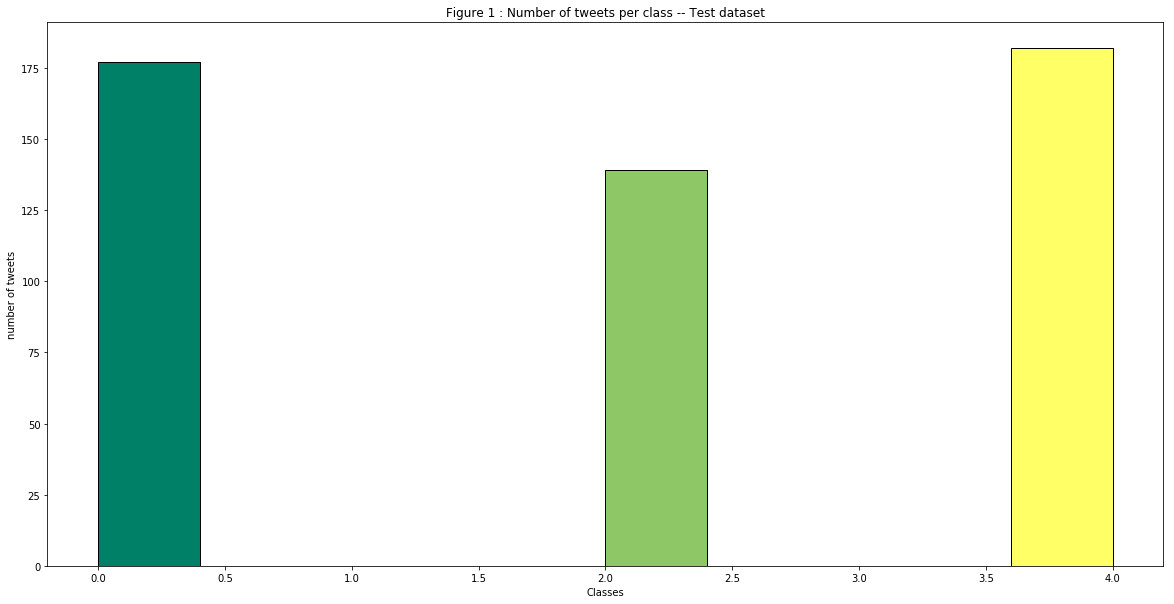

In [20]:
#Plot repartition of our tweets over our datasets
plt.figure(figsize=(20,10))

plt.ylabel("number of tweets")
plt.xlabel("Classes")
plt.title("Figure 1 : Number of tweets per class -- Test dataset")
#plt.xticks(range(4))
cm= plt.cm.get_cmap('summer')

#The histogram
n_tr, bins_tr, patches_tr = plt.hist(Y1, edgecolor='black')
bin_centers_tr = 0.5 * (bins_tr[:-1] + bins_tr[1])
col = bin_centers_tr - min(bin_centers_tr)
col /= max(col)
for c,p in zip(col, patches_tr):
    plt.setp(p, 'facecolor', cm(c))

In [21]:
#Dataset2 - 1600 tweets 800,000 pos and 800,00 negative since it is so big we take a subset of everything to not manage too much data
file = open(dataset2,encoding="latin-1")
#lines = csv.reader(file)
lines = file.readlines()
shuffle(lines)

for line in lines[:2000]:
    line = line.split(',')
    X2.append(line[5])
    Y2.append(int(line[0][1]))



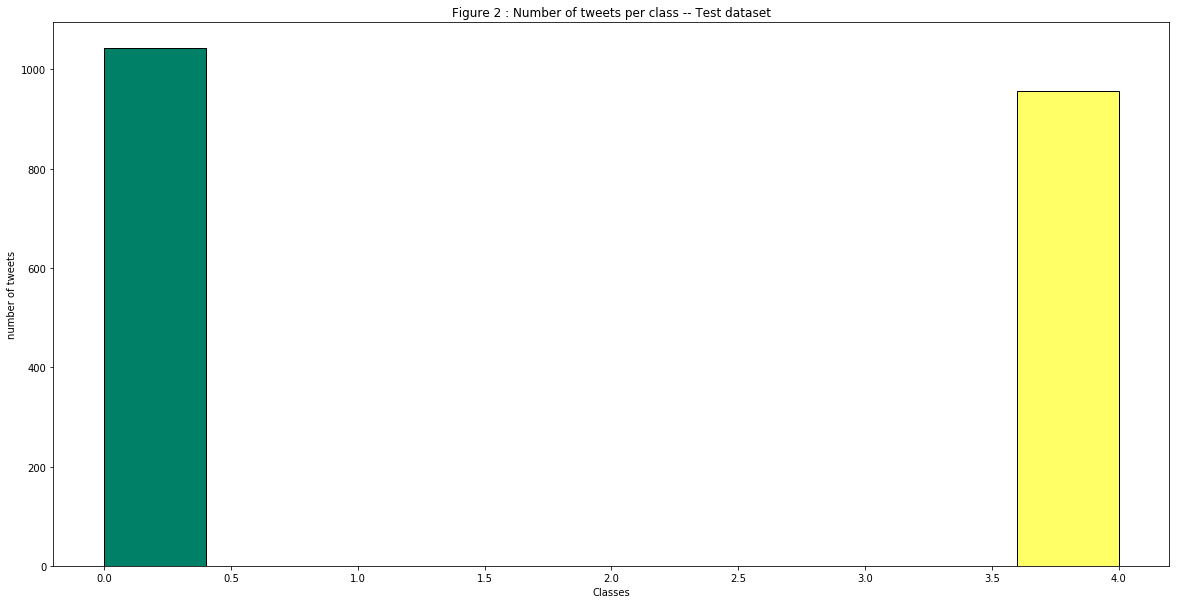

In [22]:
#Plot repartition of our tweets over our datasets
plt.figure(figsize=(20,10))

plt.ylabel("number of tweets")
plt.xlabel("Classes")
plt.title("Figure 2 : Number of tweets per class -- Test dataset")
#plt.xticks(range(4))
cm= plt.cm.get_cmap('summer')

#The histogram
n_tr, bins_tr, patches_tr = plt.hist(Y2, edgecolor='black')
bin_centers_tr = 0.5 * (bins_tr[:-1] + bins_tr[1])
col = bin_centers_tr - min(bin_centers_tr)
col /= max(col)
for c,p in zip(col, patches_tr):
    plt.setp(p, 'facecolor', cm(c))

In [23]:
#Dataset3 - VADER dataset 
file = open(dataset3)

line = file.readline()

while line :
    
    line = line.split('\t')
    
    X3.append(line[2])
    
#    Thresholds selected upon analysis of the tweets and splits 2042 positve, 1227 neutral, 931 negative
    
    if float((line[1]))>=0.8: #positive sentiment
        Y3.append(4)
    elif float(line[1])<=-0.8: #negativesentiment
        Y3.append(0)
    else: 
        Y3.append(2)
    
    
    line = file.readline()


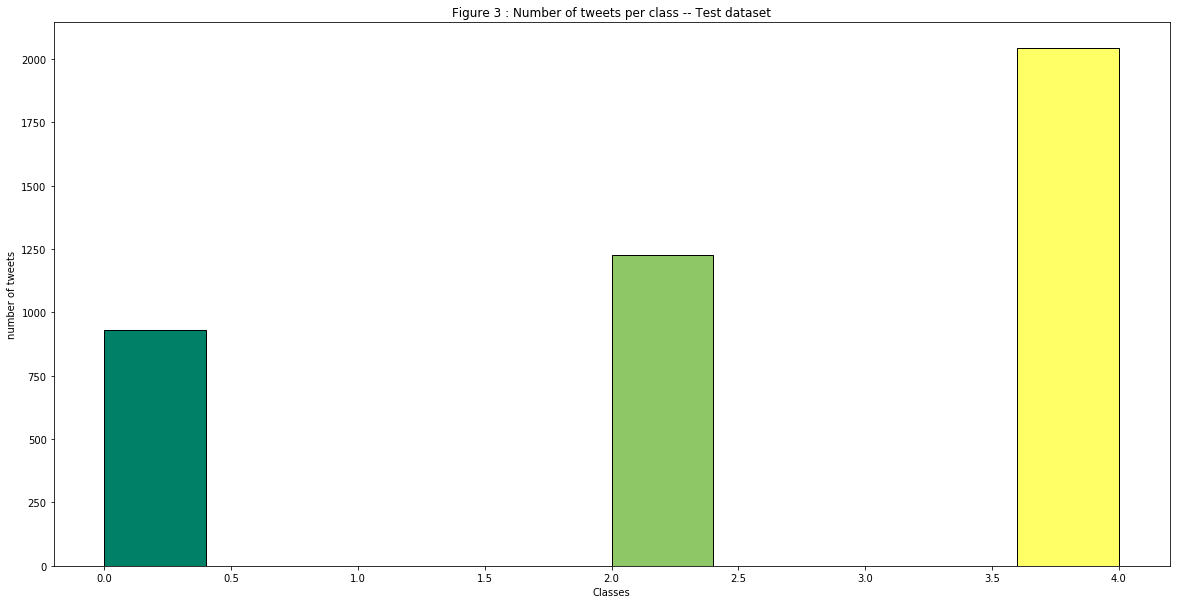

In [24]:
#Plot repartition of our tweets over our datasets
plt.figure(figsize=(20,10))

plt.ylabel("number of tweets")
plt.xlabel("Classes")
plt.title("Figure 3 : Number of tweets per class -- Test dataset")
#plt.xticks(range(4))
cm= plt.cm.get_cmap('summer')

#The histogram
n_tr, bins_tr, patches_tr = plt.hist(Y3, edgecolor='black')
bin_centers_tr = 0.5 * (bins_tr[:-1] + bins_tr[1])
col = bin_centers_tr - min(bin_centers_tr)
col /= max(col)
for c,p in zip(col, patches_tr):
    plt.setp(p, 'facecolor', cm(c))

In [25]:
#Dataset4 - 14641 tweets 2363 pos, 3100 neut, 9178 neg
file = open(dataset4,encoding="utf8")
lines = csv.reader(file)

for line in lines:
    X4.append(line[10])
    Y4_vader.append(line[2])
    
    if line[1]=='positive': #positive sentiment
        Y4.append(4)
    elif line[1]=='negative': #negativesentiment
        Y4.append(0)
    else: 
        Y4.append(2)
   #as data is skewed lets extract 3000 negatives
idx_of_rand_negatives =  random.sample( [i for i, x in enumerate(Y4) if x == 0],3000)
idx_of_pos =  random.sample( [i for i, x in enumerate(Y4) if x == 4],2363)
idx_of_neutr=  random.sample( [i for i, x in enumerate(Y4) if x == 2],3000)
idx_2_keep = idx_of_rand_negatives+idx_of_pos+idx_of_neutr
X4 = [X4[i] for i in idx_2_keep]
Y41 = [Y4[i] for i in idx_2_keep]


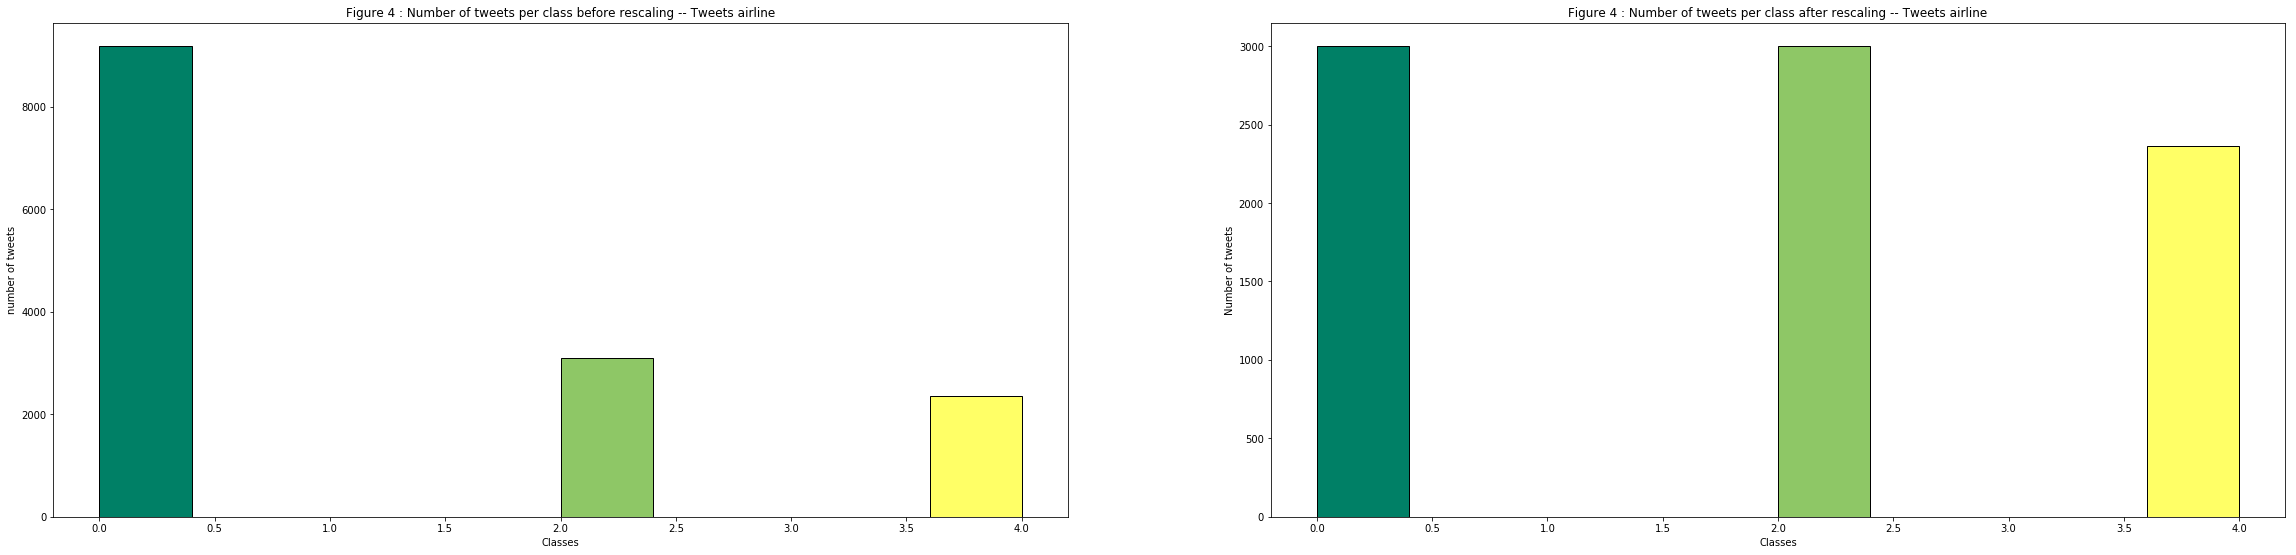

In [26]:
#Plot repartition of our tweets over our datasets
plt.figure(figsize=(40,20))

plt.subplot(2,2,1)
plt.ylabel("number of tweets")
plt.xlabel("Classes")
plt.title("Figure 4 : Number of tweets per class before rescaling -- Tweets airline")
#plt.xticks(range(4))
cm= plt.cm.get_cmap('summer')

#The histogram
n_tr, bins_tr, patches_tr = plt.hist(Y4, edgecolor='black')
bin_centers_tr = 0.5 * (bins_tr[:-1] + bins_tr[1])
col = bin_centers_tr - min(bin_centers_tr)
col /= max(col)
for c,p in zip(col, patches_tr):
    plt.setp(p, 'facecolor', cm(c))
    

plt.subplot(2,2,2)
plt.ylabel("Number of tweets")
plt.xlabel("Classes")
plt.title("Figure 4 : Number of tweets per class after rescaling -- Tweets airline")
#plt.xticks(range(4))
cm= plt.cm.get_cmap('summer')

#The histogram
n_tr, bins_tr, patches_tr = plt.hist(Y41, edgecolor='black')
bin_centers_tr = 0.5 * (bins_tr[:-1] + bins_tr[1])
col = bin_centers_tr - min(bin_centers_tr)
col /= max(col)
for c,p in zip(col, patches_tr):
    plt.setp(p, 'facecolor', cm(c))

plt.show()

In [27]:
## here we select how we construct our training/test data base by adding the previous datasets    
#X = X1 + X2 + X3 + X4
#Y = Y1 + Y2 + Y3 + Y4

##Or choose only 1 particular dataset
X = X1 + X2 
Y = Y1 + Y2 


In [28]:
#Generate X_train, X_test by splitting X
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=percentagesplit,random_state=12)
#Another way X_train=X1+X2, X_test=X3+X4

#Counting data distribution
for line in X_train:
    if line == 4:
        num_4 += 1
    elif line== 2:
        num_2 += 1
    elif line == 0:
        num_0 += 1

In [29]:
if sentdict==0: #Do not restrict the vectorizer to specific features
    sentiment_dict=None
elif sentdict==1: #Use the vader dataset to extract significant feature words from the data
    analyzer = SentimentIntensityAnalyzer()
    sentiment_dict=SentimentIntensityAnalyzer.make_lex_dict(analyzer).keys()

We are going to use the scikit-learn tf-idf to tranfrom the data https://en.wikipedia.org/wiki/Tf%E2%80%93idf and http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting than might be better that the bag of word.

In [30]:
#####===================================
##   Different vectorizers (count, binary, tfidf)
###================================
#Create different vectorizers 


vectorizer1 = CountVectorizer(dtype=int,ngram_range=(ngram_min, ngram_max),lowercase=True,max_df=0.8, min_df=1,stop_words='english', vocabulary= sentiment_dict, binary=True)

vectorizer2=CountVectorizer(dtype=int,ngram_range=(ngram_min, ngram_max),lowercase=True,max_df=0.8, min_df=1,stop_words='english', vocabulary= sentiment_dict) #

vectorizer3=TfidfVectorizer(ngram_range=(ngram_min, ngram_max), min_df=1, #Suppress word that appear in less than 10 docs
                             max_df = 0.8, #Suppress word that appear in more than 80% of the doc
                             sublinear_tf=True,
                             smooth_idf = True, # adds “1” to the numerator and denominator as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions:

use_idf=True, dtype=int,stop_words='english', vocabulary= sentiment_dict )

In [31]:
#Transform data
#Binary
train_vectors1 = vectorizer1.fit_transform(X_train) 
test_vectors1 = vectorizer1.transform(X_test)

#Count
train_vectors2 = vectorizer2.fit_transform(X_train) 
test_vectors2 = vectorizer2.transform(X_test)

#TfIdf
train_vectors3= vectorizer3.fit_transform(X_train) 
test_vectors3 = vectorizer3.transform(X_test)


In [32]:
#
## =============================================================================
## #SVM Model 1 and 2 with different vectorizers
## =============================================================================

print('Training SVM Classifiers.....')
#models _1: binary vectorizers, _2: Count _3:Tfidf

model1_1 = OneVsRestClassifier(SVM) 
model1_2 = OneVsRestClassifier(SVM)
model1_3 = OneVsRestClassifier(SVM)
model2_1 = OneVsOneClassifier(SVM)
model2_2 = OneVsOneClassifier(SVM)
model2_3 = OneVsOneClassifier(SVM)

model1_1.fit(train_vectors1,Y_train)
model2_1.fit(train_vectors1,Y_train)

model1_2.fit(train_vectors2,Y_train)
model2_2.fit(train_vectors2,Y_train)

model1_3.fit(train_vectors3,Y_train)
model2_3.fit(train_vectors3,Y_train)

Training SVM Classifiers.....


OneVsOneClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)

In [33]:
#Run cross-validation to test split for each model vectorizer pair
cv_scores1_1 = cross_val_score(model1_1, train_vectors1, Y_train, cv=5,scoring='f1_macro')
cv_scores1_2= cross_val_score(model1_2, train_vectors2, Y_train, cv=5,scoring='f1_macro')
cv_scores1_3 = cross_val_score(model1_3, train_vectors3, Y_train, cv=5,scoring='f1_macro')
cv_scores2_1 = cross_val_score(model2_1, train_vectors1, Y_train, cv=5,scoring='f1_macro')
cv_scores2_2= cross_val_score(model2_2, train_vectors2, Y_train, cv=5,scoring='f1_macro')
cv_scores2_3 = cross_val_score(model2_3, train_vectors3, Y_train, cv=5,scoring='f1_macro')

print('cv_scores1_1', cv_scores1_1)
print('cv_scores1_3', cv_scores1_2)
print('cv_scores1_3', cv_scores1_3)
print('cv_scores2_1', cv_scores2_1)
print('cv_scores2_2', cv_scores2_2)
print('cv_scores2_3 ', cv_scores2_3 )

cv_scores1_1 [ 0.62444109  0.59901896  0.56020676  0.58330291  0.61157636]
cv_scores1_3 [ 0.62049591  0.59242461  0.56763171  0.58805214  0.5976146 ]
cv_scores1_3 [ 0.51686833  0.56500145  0.54926658  0.51656483  0.51350744]
cv_scores2_1 [ 0.55759365  0.61761304  0.54845295  0.55270877  0.54108684]
cv_scores2_2 [ 0.55953498  0.5846683   0.5518904   0.52018702  0.54141219]
cv_scores2_3  [ 0.52864324  0.51198355  0.53198425  0.49097679  0.5180932 ]


In [34]:
#Test the data
print('Testing SVM Accuracy.....')

resultsY_11 = model1_1.predict(test_vectors1)
resultsY_21 = model2_1.predict(test_vectors1)

resultsY_12 = model1_2.predict(test_vectors2)
resultsY_22 = model2_2.predict(test_vectors2)

resultsY_13 = model1_3.predict(test_vectors3)
resultsY_23 = model2_3.predict(test_vectors3)

precision11, recall11, score11, support11 = metrics.precision_recall_fscore_support(Y_test,resultsY_11 )
precision21, recall21, score21, support21 = metrics.precision_recall_fscore_support(Y_test,resultsY_21 )
accuracy11 = metrics.accuracy_score(Y_test,resultsY_11)
accuracy21 = metrics.accuracy_score(Y_test,resultsY_21)
confusionmatrix11=metrics.confusion_matrix(Y_test,resultsY_11)
confusionmatrix21=metrics.confusion_matrix(Y_test,resultsY_21)

precision12, recall12, score12, support12 = metrics.precision_recall_fscore_support(Y_test,resultsY_12 )
precision22, recall22, score22, support22 = metrics.precision_recall_fscore_support(Y_test,resultsY_22 )
accuracy12 = metrics.accuracy_score(Y_test,resultsY_12)
accuracy22 = metrics.accuracy_score(Y_test,resultsY_22)
confusionmatrix12=metrics.confusion_matrix(Y_test,resultsY_12)
confusionmatrix22=metrics.confusion_matrix(Y_test,resultsY_22)

precision13, recall13, score13, support13 = metrics.precision_recall_fscore_support(Y_test,resultsY_13 )
precision23, recall23, score23, support23 = metrics.precision_recall_fscore_support(Y_test,resultsY_23 )
accuracy13 = metrics.accuracy_score(Y_test,resultsY_13)
accuracy23 = metrics.accuracy_score(Y_test,resultsY_23)
confusionmatrix13=metrics.confusion_matrix(Y_test,resultsY_13)
confusionmatrix23=metrics.confusion_matrix(Y_test,resultsY_23)

Testing SVM Accuracy.....


In [35]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = [0, 2, 4]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
print('__________________________________________') 
print('RESULTS - Model 1 - OneVsRestClassifier(LinearSVC())') 
print('__________________________________________') 

print ('BINARY')
print('Accuracy', accuracy11)
print('F1_score', score11)
print('                                        ') 
print ('COUNT')
print('Accuracy', accuracy12)
print('F1_score', score12)
print('                                        ') 
print ('TFIDF')
print('Accuracy', accuracy13)
print('F1_score', score13)
print('__________________________________________') 
print('__________________________________________') 
print('                                        ') 
print('RESULTS - Model 2 - OneVsOneClassifier(LinearSVC())') 
print('__________________________________________') 
print('                                        ') 
print ('BINARY')
print('Accuracy', accuracy21)
print('F1_score', score21)
print('                                        ') 
print ('COUNT')
print('Accuracy', accuracy22)
print('F1_score', score22)
print('                                        ') 
print ('TFIDF')
print('Accuracy', accuracy23)
print('F1_score', score23)
print('__________________________________________') 
print('__________________________________________') 

__________________________________________
RESULTS - Model 1 - OneVsRestClassifier(LinearSVC())
__________________________________________
BINARY
Accuracy 0.656
F1_score [ 0.70544554  0.47457627  0.60979463]
                                        
COUNT
Accuracy 0.657333333333
F1_score [ 0.70719603  0.47457627  0.61102362]
                                        
TFIDF
Accuracy 0.664
F1_score [ 0.70633894  0.52631579  0.62980031]
__________________________________________
__________________________________________
                                        
RESULTS - Model 2 - OneVsOneClassifier(LinearSVC())
__________________________________________
                                        
BINARY
Accuracy 0.648
F1_score [ 0.69727047  0.46666667  0.60252366]
                                        
COUNT
Accuracy 0.653333333333
F1_score [ 0.70149254  0.44067797  0.6122449 ]
                                        
TFIDF
Accuracy 0.661333333333
F1_score [ 0.70649351  0.47368421  0.6299694

Normalized confusion matrix
[[ 0.72  0.02  0.26]
 [ 0.12  0.48  0.4 ]
 [ 0.36  0.02  0.62]]
Normalized confusion matrix
[[ 0.72  0.02  0.26]
 [ 0.14  0.43  0.43]
 [ 0.35  0.03  0.62]]


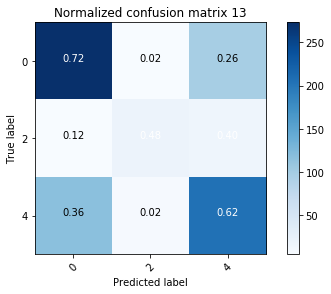

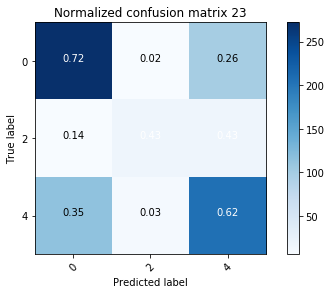

In [37]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plt.figure()

plot_confusion_matrix(confusionmatrix13, classes=class_names, normalize=True,
                      title='Normalized confusion matrix 13')
plt.figure()
plot_confusion_matrix(confusionmatrix23, classes=class_names, normalize=True,
                      title='Normalized confusion matrix 23')


In [38]:
#
## =============================================================================
## #DecisionTreeClassifier with different vectorizers - 2 criterion  : “gini” for the Gini impurity and “entropy” for the information gain.
## =============================================================================

print('Training Decision Tree Classifiers.....')
#tree _1: binary vectorizers, _2: Count _3:Tfidf


treeGini_1 = tree.DecisionTreeClassifier(criterion='gini')
treeGini_2 = tree.DecisionTreeClassifier(criterion='gini')
treeGini_3 = tree.DecisionTreeClassifier(criterion='gini')

treeEntropy_1 = tree.DecisionTreeClassifier(criterion='entropy')
treeEntropy_2 = tree.DecisionTreeClassifier(criterion='entropy')
treeEntropy_3 = tree.DecisionTreeClassifier(criterion='entropy')

treeGini_1.fit(train_vectors1,Y_train)
treeGini_2.fit(train_vectors2,Y_train)
treeGini_3.fit(train_vectors3,Y_train)


treeEntropy_1.fit(train_vectors1,Y_train)
treeEntropy_2.fit(train_vectors2,Y_train)
treeEntropy_3.fit(train_vectors3,Y_train)


Training Decision Tree Classifiers.....


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [39]:
#Run cross-validation to test split for each model vectorizer pair
cv_scoresGini_1 = cross_val_score(treeGini_1, train_vectors1, Y_train, cv=5,scoring='f1_macro')
cv_scoresGini_2= cross_val_score(treeGini_2, train_vectors2, Y_train, cv=5,scoring='f1_macro')
cv_scoresGini_3 = cross_val_score(treeGini_3, train_vectors3, Y_train, cv=5,scoring='f1_macro')
cv_scoresEntropy_1 = cross_val_score(treeEntropy_1, train_vectors1, Y_train, cv=5,scoring='f1_macro')
cv_scoresEntropy_2= cross_val_score(treeEntropy_2, train_vectors2, Y_train, cv=5,scoring='f1_macro')
cv_scoresEntropy_3 = cross_val_score(treeEntropy_3, train_vectors3, Y_train, cv=5,scoring='f1_macro')

print('cv_scoresGini_1', cv_scoresGini_1)
print('cv_scoresGini_3', cv_scoresGini_2)
print('cv_scoresGini_3', cv_scoresGini_3)
print('cv_scoresEntropy_1', cv_scoresEntropy_1)
print('cv_scoresEntropy_2', cv_scoresEntropy_2)
print('cv_scoresEntropy_3 ', cv_scoresEntropy_3 )

cv_scoresGini_1 [ 0.52  0.59  0.59  0.52  0.59]
cv_scoresGini_3 [ 0.5   0.58  0.55  0.53  0.62]
cv_scoresGini_3 [ 0.57  0.57  0.57  0.52  0.59]
cv_scoresEntropy_1 [ 0.55  0.6   0.56  0.52  0.61]
cv_scoresEntropy_2 [ 0.54  0.58  0.59  0.55  0.57]
cv_scoresEntropy_3  [ 0.58  0.58  0.53  0.54  0.56]


In [40]:
#Test the data
print('Testing Decision Tree Classifier Accuracy.....')

resultsY_11 = treeGini_1.predict(test_vectors1)
resultsY_21 = treeEntropy_1.predict(test_vectors1)

resultsY_12 = treeGini_2.predict(test_vectors2)
resultsY_22 = treeEntropy_2.predict(test_vectors2)

resultsY_13 = treeGini_3.predict(test_vectors3)
resultsY_23 = treeEntropy_3.predict(test_vectors3)

precision11, recall11, score11, support11 = metrics.precision_recall_fscore_support(Y_test,resultsY_11 )
precision21, recall21, score21, support21 = metrics.precision_recall_fscore_support(Y_test,resultsY_21 )
accuracy11 = metrics.accuracy_score(Y_test,resultsY_11)
accuracy21 = metrics.accuracy_score(Y_test,resultsY_21)
confusionmatrix11=metrics.confusion_matrix(Y_test,resultsY_11)
confusionmatrix21=metrics.confusion_matrix(Y_test,resultsY_21)

precision12, recall12, score12, support12 = metrics.precision_recall_fscore_support(Y_test,resultsY_12 )
precision22, recall22, score22, support22 = metrics.precision_recall_fscore_support(Y_test,resultsY_22 )
accuracy12 = metrics.accuracy_score(Y_test,resultsY_12)
accuracy22 = metrics.accuracy_score(Y_test,resultsY_22)
confusionmatrix12=metrics.confusion_matrix(Y_test,resultsY_12)
confusionmatrix22=metrics.confusion_matrix(Y_test,resultsY_22)

precision13, recall13, score13, support13 = metrics.precision_recall_fscore_support(Y_test,resultsY_13 )
precision23, recall23, score23, support23 = metrics.precision_recall_fscore_support(Y_test,resultsY_23 )
accuracy13 = metrics.accuracy_score(Y_test,resultsY_13)
accuracy23 = metrics.accuracy_score(Y_test,resultsY_23)
confusionmatrix13=metrics.confusion_matrix(Y_test,resultsY_13)
confusionmatrix23=metrics.confusion_matrix(Y_test,resultsY_23)

Testing Decision Tree Classifier Accuracy.....


In [41]:
print('__________________________________________') 
print('RESULTS Decision Tree Classifier - Model on Gini impurity ') 
print('__________________________________________') 

print ('BINARY')
print('Accuracy', accuracy11)
print('F1_score', score11)
print('                                        ') 
print ('COUNT')
print('Accuracy', accuracy12)
print('F1_score', score12)
print('                                        ') 
print ('TFIDF')
print('Accuracy', accuracy13)
print('F1_score', score13)
print('__________________________________________') 
print('__________________________________________') 
print('                                        ') 
print('RESULTS Decision Tree Classifier  - Model on information gain (Entropy)') 
print('__________________________________________') 
print ('BINARY')
print('Accuracy', accuracy21)
print('F1_score', score21)
print('                                        ') 
print ('COUNT')
print('Accuracy', accuracy22)
print('F1_score', score22)
print('                                        ') 
print ('TFIDF')
print('Accuracy', accuracy23)
print('F1_score', score23)
print('__________________________________________') 
print('__________________________________________') 

__________________________________________
RESULTS Decision Tree Classifier - Model on Gini impurity 
__________________________________________
BINARY
Accuracy 0.616
F1_score [ 0.68  0.56  0.54]
                                        
COUNT
Accuracy 0.612
F1_score [ 0.67  0.51  0.55]
                                        
TFIDF
Accuracy 0.586666666667
F1_score [ 0.65  0.24  0.53]
__________________________________________
__________________________________________
                                        
RESULTS Decision Tree Classifier  - Model on information gain (Entropy)
__________________________________________
BINARY
Accuracy 0.629333333333
F1_score [ 0.69  0.47  0.56]
                                        
COUNT
Accuracy 0.636
F1_score [ 0.69  0.52  0.57]
                                        
TFIDF
Accuracy 0.569333333333
F1_score [ 0.63  0.27  0.51]
__________________________________________
__________________________________________


Normalized confusion matrix
[[ 0.73  0.01  0.26]
 [ 0.14  0.52  0.33]
 [ 0.47  0.03  0.5 ]]
Normalized confusion matrix
[[ 0.71  0.01  0.27]
 [ 0.67  0.19  0.14]
 [ 0.53  0.01  0.45]]


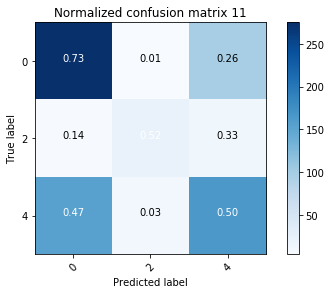

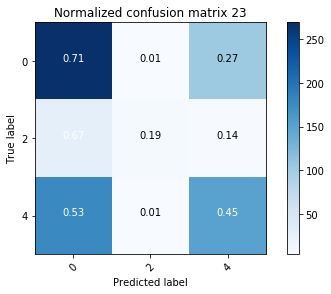

In [42]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plt.figure()

plot_confusion_matrix(confusionmatrix11, classes=class_names, normalize=True,
                      title='Normalized confusion matrix 11')
plt.figure()
plot_confusion_matrix(confusionmatrix23, classes=class_names, normalize=True,
                      title='Normalized confusion matrix 23')

In [55]:
#
## =============================================================================
## #Naive Bayes using Multinomial or Gaussian Classifiers
## =============================================================================

print('Training Naive Classifiers.....')
#models _1: binary vectorizers, _2: Count _3:Tfidf
 
multi1_1 = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
multi1_2 = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
multi1_3 = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#gaussian2_1 = GaussianNB()
#gaussian2_2 = GaussianNB()
#gaussian2_3 = GaussianNB()

multi1_1.fit(train_vectors1,Y_train)
#gaussian2_1.fit(train_vectors1,Y_train)

multi1_2.fit(train_vectors2,Y_train)
#gaussian2_2.fit(train_vectors2,Y_train)

multi1_3.fit(train_vectors3,Y_train)
#gaussian2_3.fit(train_vectors3,Y_train)

Training Naive Classifiers.....


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
#Run cross-validation to test split for each model vectorizer pair
cv_scoresMutli_1 = cross_val_score(multi1_1, train_vectors1, Y_train, cv=5,scoring='f1_macro')
cv_scoresMutli_2= cross_val_score(multi1_2, train_vectors2, Y_train, cv=5,scoring='f1_macro')
cv_scoresMutli_3 = cross_val_score(multi1_3, train_vectors3, Y_train, cv=5,scoring='f1_macro')


print('cv_scoresMutli_1', cv_scoresMutli_1)
print('cv_scoresMutli_3', cv_scoresMutli_2)
print('cv_scoresMutli_3', cv_scoresMutli_3)


cv_scoresMutli_1 [ 0.52  0.55  0.52  0.51  0.53]
cv_scoresMutli_3 [ 0.53  0.55  0.53  0.52  0.54]
cv_scoresMutli_3 [ 0.46  0.42  0.43  0.44  0.45]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:111

In [57]:
#Test the data
print('Testing Naïve Bayes Classifier Accuracy.....')

resultsY_multi1 = multi1_1.predict(test_vectors1)

resultsY_multi2 = multi1_2.predict(test_vectors2)


resultsY_multi3 = multi1_3.predict(test_vectors3)

precision11, recall11, score11, support11 = metrics.precision_recall_fscore_support(Y_test,resultsY_multi1 )
accuracy11 = metrics.accuracy_score(Y_test,resultsY_multi1)
confusionmatrix11=metrics.confusion_matrix(Y_test,resultsY_multi1)


precision12, recall12, score12, support12 = metrics.precision_recall_fscore_support(Y_test,resultsY_multi2 )
accuracy12 = metrics.accuracy_score(Y_test,resultsY_multi2)
confusionmatrix12=metrics.confusion_matrix(Y_test,resultsY_multi2)


precision13, recall13, score13, support13 = metrics.precision_recall_fscore_support(Y_test,resultsY_multi3)
accuracy13 = metrics.accuracy_score(Y_test,resultsY_multi3)
confusionmatrix13=metrics.confusion_matrix(Y_test,resultsY_multi3)

Testing Naïve Bayes Classifier Accuracy.....


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
print('__________________________________________') 
print('RESULTS Naive Bayes Classifier ') 
print('__________________________________________') 

print ('BINARY')
print('Accuracy', accuracy11)
print('F1_score', score11)
print('                                        ') 
print ('COUNT')
print('Accuracy', accuracy12)
print('F1_score', score12)
print('                                        ') 
print ('TFIDF')
print('Accuracy', accuracy13)
print('F1_score', score13)
print('__________________________________________') 


__________________________________________
RESULTS Naive Bayes Classifier 
__________________________________________
BINARY
Accuracy 0.666666666667
F1_score [ 0.72  0.32  0.63]
                                        
COUNT
Accuracy 0.66
F1_score [ 0.71  0.32  0.63]
                                        
TFIDF
Accuracy 0.656
F1_score [ 0.72  0.    0.62]
__________________________________________


Normalized confusion matrix
[[ 0.73  0.01  0.26]
 [ 0.19  0.21  0.6 ]
 [ 0.35  0.01  0.64]]
Normalized confusion matrix
[[ 0.78  0.    0.22]
 [ 0.21  0.    0.79]
 [ 0.4   0.    0.6 ]]


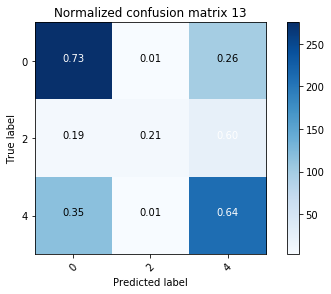

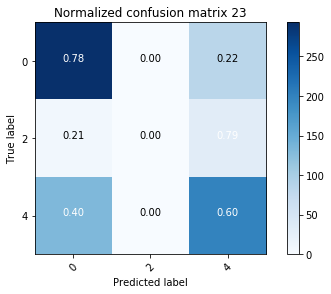

In [59]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plt.figure()

plot_confusion_matrix(confusionmatrix12, classes=class_names, normalize=True,
                      title='Normalized confusion matrix 13')
plt.figure()
plot_confusion_matrix(confusionmatrix13, classes=class_names, normalize=True,
                      title='Normalized confusion matrix 23')

In [60]:
## =============================================================================
## Apply Vader analysis on test set
## ============================================================================= 
vader_scores_test=[]
vader_scores_test_mod=[]
analyzer = SentimentIntensityAnalyzer() # create a vader analyzer
for tweet in X_test:
    vader_scores_test.append(analyzer.polarity_scores(tweet)['compound'])#apply analyser to tweet set

#convert scores to positive, neg and neutral, 0.3 was chosen due to the compound score being between 1 and neg 1
for score in vader_scores_test:
    if float(score)>=0.30: #positive sentiment
        vader_scores_test_mod.append(4)
    elif float(score)<=-0.30: #negativesentiment
        vader_scores_test_mod.append(0)
    else: 
        vader_scores_test_mod.append(2)
    
precision_vader, recall_vader, score_vader, support_vader = metrics.precision_recall_fscore_support( Y_test,vader_scores_test_mod)
accuracy_vader = metrics.accuracy_score( Y_test,vader_scores_test_mod)
confusionmatrix_vader=metrics.confusion_matrix( Y_test,vader_scores_test_mod)

print('RESULTS - VADER') 
print('__________________________________________') 
print('Accuracy', accuracy_vader)
print('F1_score',score_vader)
print('__________________________________________') 
print('__________________________________________') 


RESULTS - VADER
__________________________________________
Accuracy 0.428
F1_score [ 0.42  0.18  0.6 ]
__________________________________________
__________________________________________


Normalized confusion matrix
[[ 0.28  0.51  0.21]
 [ 0.    0.86  0.14]
 [ 0.05  0.4   0.54]]


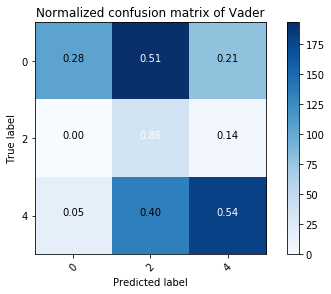

In [61]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plt.figure()

plot_confusion_matrix(confusionmatrix_vader, classes=class_names, normalize=True,
                      title='Normalized confusion matrix of Vader')


In [62]:
   
### =============================================================================
### Apply best model to twitter data and print a selection of results
### =============================================================================
# NOTE: Current best model is Model1_3 One vs rest tdif vectorizer, with current parameters
file = open('olympics.json','r')
text = file.read()
split_text = text.split('\n')
split_text.pop() #Last elemnt is empty because of the split

tweet_test = [json.loads(data)['text'] for data in split_text]

# In[65]:

tweet_vector = vectorizer3.transform(tweet_test)
tweet_prediction = model1_3.predict(tweet_vector)

In [63]:
#print 2 random tweets of each predicted class 
neutral_ind=(tweet_prediction==2).nonzero()[0]
pos_ind=(tweet_prediction==4).nonzero()[0]
neg_ind=(tweet_prediction==0).nonzero()[0]

tweet_test=np.asarray(tweet_test)
neutral=tweet_test[neutral_ind]
pos=tweet_test[pos_ind]
neg=tweet_test[neg_ind]
tweet_test=tweet_test.tolist()

rand_smpl_neutral = [ neutral[i] for i in sorted(random.sample(range(len(neutral)), 2)) ]
rand_smpl_pos = [ pos[i] for i in sorted(random.sample(range(len(pos)), 2)) ]
rand_smpl_neg = [ neg[i] for i in sorted(random.sample(range(len(neg)), 2)) ]
print('__________________________________________') 
print('___________PREDICTIONS_______________') 
print('__________________________________________') 

print('__________________________________________') 
print('NEUTRAL')
print(rand_smpl_neutral)
print('__________________________________________') 
print('POSITIVE')
print(rand_smpl_pos)
print('__________________________________________') 
print('NEGATIVE')
print(rand_smpl_neg)

__________________________________________
___________PREDICTIONS_______________
__________________________________________
__________________________________________
NEUTRAL
['Can we just call “bone density issues from struggling with nutrition” what it is? It’s an eating disorder. Can the… https://t.co/Sm69FB6T1d', 'Critiquing #Olympics athletes while eating Ben &amp; Jerrys on the couch']
__________________________________________
POSITIVE
['Shortly after 11 EST, it’s the women of @usahockey against @HC_Women for gold at the #Olympics. #USA @TeamUSA #TeamUSA', 'Great job @MaiaShibutani and @AlexShibutani!! #Olympics #FigureSKating #PyeongChang2018 #TeamUSA #USA']
__________________________________________
NEGATIVE
['@SchittsCreekPop I’m going to have to watch tomorrow!! Right now #womenshockey #USAvCAN 🏒\U0001f945🇺🇸🇨🇦\U0001f947 #Olympics #SchittsCreek', 'Speed skating relay = most intense Olympic sport ever. Holy cow #Olympics']


In [64]:

## =============================================================================
## Apply Vader analysis and compare scores, <=-0.8: #negativesentiment >=0.8: #positive sentiment
## ============================================================================= 
vader_scores_orig=[]
vader_scores=[]

analyzer = SentimentIntensityAnalyzer() # create a vader analyzer
for tweet in tweet_test:
    vader_scores_orig.append(analyzer.polarity_scores(tweet)['compound'])#apply analyser to tweet set

#convert scores to positive, neg and neutral 
for score in vader_scores_orig:
    if float(score)>=0.8: #positive sentiment
        vader_scores.append(4)
    elif float(score)<=-0.8: #negativesentiment
        vader_scores.append(0)
    else: 
        vader_scores.append(2)


In [65]:
## =============================================================================
## Analyse results
## ============================================================================= 

precisionT, recallT, scoreT, supportT = metrics.precision_recall_fscore_support( vader_scores,tweet_prediction )
accuracyT = metrics.accuracy_score( vader_scores,tweet_prediction)
confusionmatrixT=metrics.confusion_matrix( vader_scores,tweet_prediction)

print('TWEET- Model-Vader comparison') 
print('__________________________________________') 
print('Accuracy', accuracyT)
print('F1_score', scoreT)
print('__________________________________________') 
print('__________________________________________') 


TWEET- Model-Vader comparison
__________________________________________
Accuracy 0.062
F1_score [ 0.02  0.    0.2 ]
__________________________________________
__________________________________________
